In [5]:
#!/usr/bin/env python3
import numpy as np
import pickle
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from scipy.special import softmax
from skbio.stats.composition import clr

# -----------------------------
# CONFIG
# -----------------------------
VIT_PATH    = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH = '/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy'
AREAS_PATH  = '/home/maria/MITNeuralComputation/visualization/brain_area.npy'
AREA_NAME   = 'VISl'
N_IMAGES, N_TRIALS = 118, 50
VAR_CUTOFF  = 0.90
RANDOM_SEED = 42
ALPHAS = np.logspace(-4, 3, 20)  # ridge grid

rng = np.random.default_rng(RANDOM_SEED)

# -----------------------------
# ViT embeddings (unchanged)
# -----------------------------
with open(VIT_PATH, 'rb') as f:
    vit_logits = pickle.load(f)['natural_scenes']

Xv = softmax(np.asarray(vit_logits), axis=1)
Xv = clr(Xv + 1e-12)
vit_pca_full = PCA(random_state=RANDOM_SEED).fit(Xv)
vit_ncomp = np.searchsorted(np.cumsum(vit_pca_full.explained_variance_ratio_), VAR_CUTOFF) + 1
vit_pca = PCA(n_components=vit_ncomp, random_state=RANDOM_SEED)
Zv = vit_pca.fit_transform(Xv)  # (images × vit_ncomp)
Zv -= Zv.mean(axis=0, keepdims=True)

print(f"ViT PCs covering 90% variance: {vit_ncomp}")

# -----------------------------
# Load neural data & split repeats
# -----------------------------
dat = np.load(NEURAL_PATH, mmap_mode='r')  # (neurons × (images*trials*time))
areas = np.load(AREAS_PATH, allow_pickle=True)
mask = (areas == AREA_NAME)
dat = dat[mask]

n_neurons, n_total = dat.shape
n_time = n_total // (N_IMAGES * N_TRIALS)
dat = dat.reshape(n_neurons, N_IMAGES, N_TRIALS, n_time)

# deterministic split: odd vs even trials
idx = np.arange(N_TRIALS)
train_trials = idx[::2]      # 0,2,4,...
test_trials  = idx[1::2]     # 1,3,5,...

X_train = dat[:, :, train_trials, :].mean(axis=(2,3))  # (neurons × images)
X_test  = dat[:, :, test_trials,  :].mean(axis=(2,3))

# -----------------------------
# PCA on neural train only, project both
# -----------------------------
brain_pca_full = PCA(random_state=RANDOM_SEED).fit(X_train.T)
brain_ncomp = np.searchsorted(np.cumsum(brain_pca_full.explained_variance_ratio_), VAR_CUTOFF) + 1
brain_pca = PCA(n_components=brain_ncomp, random_state=RANDOM_SEED)
Zb_train = brain_pca.fit_transform(X_train.T)  # (images × brain_ncomp) using train mean/components
# Project test using *train* centering/components:
Zb_test = (X_test.T - brain_pca.mean_) @ brain_pca.components_.T

# center both splits in the latent space
Zb_train -= Zb_train.mean(axis=0, keepdims=True)
Zb_test  -= Zb_test.mean(axis=0,  keepdims=True)

print(f"{AREA_NAME} PCs covering 90% variance (train): {brain_ncomp}")

# -----------------------------
# Cross-validated cross-covariance SVD (cvPCA-style)
# -----------------------------
# cross-covariance of ViT vs *test* neural PCs (no leakage)
C_cv = (Zv.T @ Zb_test) / Zv.shape[0]   # (vit_ncomp × brain_ncomp)
U, S_cv, Vt = np.linalg.svd(C_cv, full_matrices=False)
shared_frac = S_cv**2 / np.sum(S_cv**2)

print("\n===== Cross-domain cvPCA (cross-validated) =====")
for i, (s, frac) in enumerate(zip(S_cv, shared_frac), 1):
    print(f"Component {i:2d}: σ_cv = {s:.4f} | fraction = {frac*100:.2f}%")

# -----------------------------
# Cross-validated prediction: ViT -> neural PCs (ridge)
# -----------------------------
# Fit on train split (images are samples)
ridge = RidgeCV(alphas=ALPHAS, fit_intercept=False)
ridge.fit(Zv, Zb_train)           # learns W: (vit_ncomp → brain_ncomp)
Zb_test_hat = ridge.predict(Zv)   # predict *test* responses using same stimuli

# Evaluate R^2 on test
ss_res = np.sum((Zb_test - Zb_test_hat)**2, axis=0)
ss_tot = np.sum((Zb_test - Zb_test.mean(axis=0))**2, axis=0)
R2_per_pc = 1.0 - ss_res/ss_tot
R2_mean = float(np.mean(R2_per_pc))

print(f"\n===== Cross-validated prediction =====")
print(f"R^2 (mean over brain PCs) = {R2_mean:.3f}")
print(f"Median R^2 over PCs       = {np.median(R2_per_pc):.3f}")
print(f"Best alpha (ridge)        = {ridge.alpha_:.4g}")

# -----------------------------
# Optional: noise ceiling via split-half reliability
# -----------------------------
# Pearson corr per PC between train and test (across images)
num = np.sum((Zb_train - Zb_train.mean(0)) * (Zb_test - Zb_test.mean(0)), axis=0)
den = np.sqrt(np.sum((Zb_train - Zb_train.mean(0))**2, axis=0) * np.sum((Zb_test - Zb_test.mean(0))**2, axis=0))
rho_split = np.clip(num/den, -1, 1)
# Spearman–Brown corrected reliability
ceiling = (2 * rho_split) / (1 + rho_split + 1e-12)

# Normalized predictive performance (accounting for noise)
R2_norm = np.clip(R2_per_pc / np.maximum(ceiling, 1e-6), 0, 1)
print("\n===== Noise ceiling =====")
print(f"Median split-half (SB) reliability = {np.median(ceiling):.3f}")
print(f"Median noise-normalized R^2        = {np.median(R2_norm):.3f}")

# Save if you want
np.savez(f"vit_{AREA_NAME}_cvpca_cv_results.npz",
         S_cv=S_cv, shared_frac=shared_frac,
         U=U, V=Vt.T,
         R2_per_pc=R2_per_pc, R2_mean=R2_mean,
         ridge_alpha=ridge.alpha_,
         ceiling=ceiling, R2_norm=R2_norm)


ViT PCs covering 90% variance: 44
VISl PCs covering 90% variance (train): 89

===== Cross-domain cvPCA (cross-validated) =====
Component  1: σ_cv = 10.6914 | fraction = 40.09%
Component  2: σ_cv = 7.6420 | fraction = 20.48%
Component  3: σ_cv = 4.2787 | fraction = 6.42%
Component  4: σ_cv = 3.6343 | fraction = 4.63%
Component  5: σ_cv = 3.4891 | fraction = 4.27%
Component  6: σ_cv = 3.1647 | fraction = 3.51%
Component  7: σ_cv = 2.5821 | fraction = 2.34%
Component  8: σ_cv = 2.5419 | fraction = 2.27%
Component  9: σ_cv = 2.2252 | fraction = 1.74%
Component 10: σ_cv = 2.0093 | fraction = 1.42%
Component 11: σ_cv = 1.9500 | fraction = 1.33%
Component 12: σ_cv = 1.7834 | fraction = 1.12%
Component 13: σ_cv = 1.7117 | fraction = 1.03%
Component 14: σ_cv = 1.6249 | fraction = 0.93%
Component 15: σ_cv = 1.5594 | fraction = 0.85%
Component 16: σ_cv = 1.4436 | fraction = 0.73%
Component 17: σ_cv = 1.3354 | fraction = 0.63%
Component 18: σ_cv = 1.2222 | fraction = 0.52%
Component 19: σ_cv = 1.2


🔁 Bootstrapping over 500 stimulus resamples...

===== Bootstrap stability of shared singular values =====
σ 1: 13.3180 ± 1.6440  (95% CI [10.541, 16.712])
σ 2: 9.4813 ± 1.1433  (95% CI [7.382, 11.728])
σ 3: 6.2931 ± 0.7928  (95% CI [5.063, 8.122])
σ 4: 5.2569 ± 0.5023  (95% CI [4.423, 6.320])
σ 5: 4.6118 ± 0.3977  (95% CI [3.936, 5.464])
σ 6: 4.0756 ± 0.3361  (95% CI [3.448, 4.756])
σ 7: 3.6582 ± 0.2859  (95% CI [3.124, 4.211])
σ 8: 3.3204 ± 0.2596  (95% CI [2.821, 3.858])
σ 9: 3.0109 ± 0.2384  (95% CI [2.605, 3.560])
σ10: 2.7484 ± 0.2093  (95% CI [2.376, 3.182])


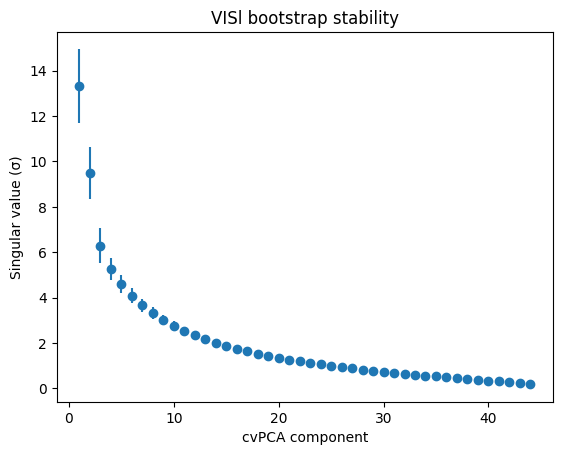

In [7]:
# -----------------------------
# Bootstrap over stimuli
# -----------------------------
N_BOOT = 500
S_boot = np.zeros((N_BOOT, len(S_cv)))

print(f"\n🔁 Bootstrapping over {N_BOOT} stimulus resamples...")
for b in range(N_BOOT):
    idx = rng.integers(0, Zv.shape[0], Zv.shape[0])  # sample 118 indices w/ replacement
    Zv_boot = Zv[idx]
    Zb_boot = Zb_test[idx]

    Cb = (Zv_boot.T @ Zb_boot) / Zv_boot.shape[0]
    _, S_b, _ = np.linalg.svd(Cb, full_matrices=False)
    S_boot[b, :len(S_b)] = S_b

S_mean = S_boot.mean(axis=0)
S_std  = S_boot.std(axis=0)
S_ci95 = np.percentile(S_boot, [2.5, 97.5], axis=0)

print("\n===== Bootstrap stability of shared singular values =====")
for i in range(min(10, len(S_cv))):
    print(f"σ{i+1:2d}: {S_mean[i]:.4f} ± {S_std[i]:.4f}  (95% CI [{S_ci95[0,i]:.3f}, {S_ci95[1,i]:.3f}])")

# Optional: save bootstrap arrays
np.savez(f"vit_{AREA_NAME}_cvpca_bootstrap.npz",
         S_boot=S_boot, S_mean=S_mean, S_std=S_std, S_ci95=S_ci95)

import matplotlib.pyplot as plt
plt.errorbar(range(1,len(S_mean)+1), S_mean, yerr=S_std, fmt='o')
plt.xlabel("cvPCA component")
plt.ylabel("Singular value (σ)")
plt.title(f"{AREA_NAME} bootstrap stability")
plt.show()


🔀 Generating shuffled null distribution (500 bootstraps)...

===== Null (shuffled) shared singular values =====
σ 1_null: 6.9842 ± 0.6763 (95% CI [5.979, 8.510])
σ 2_null: 5.5616 ± 0.5126 (95% CI [4.631, 6.623])
σ 3_null: 4.0187 ± 0.3381 (95% CI [3.433, 4.740])
σ 4_null: 3.4526 ± 0.2259 (95% CI [3.061, 3.946])
σ 5_null: 3.0464 ± 0.1818 (95% CI [2.716, 3.426])
σ 6_null: 2.7337 ± 0.1404 (95% CI [2.495, 3.050])
σ 7_null: 2.4969 ± 0.1226 (95% CI [2.273, 2.738])
σ 8_null: 2.2851 ± 0.1011 (95% CI [2.093, 2.485])
σ 9_null: 2.1180 ± 0.0927 (95% CI [1.933, 2.294])
σ10_null: 1.9672 ± 0.0864 (95% CI [1.798, 2.143])


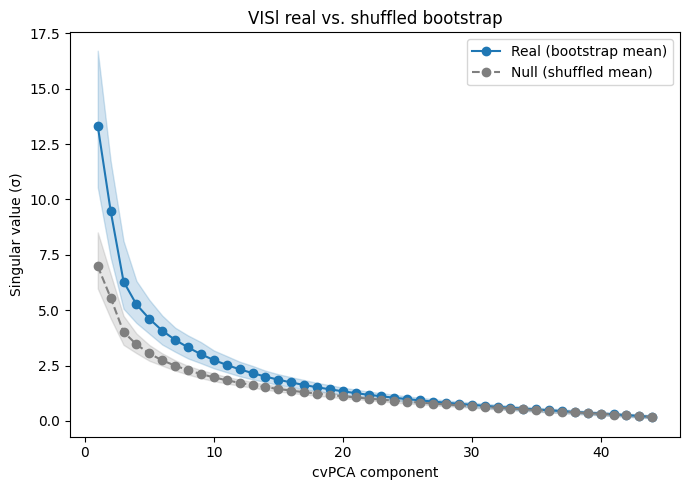

In [8]:
# -----------------------------
# Null bootstrap (stimulus-shuffled)
# -----------------------------
N_BOOT_NULL = 500
S_null = np.zeros((N_BOOT_NULL, len(S_cv)))

print(f"\n🔀 Generating shuffled null distribution ({N_BOOT_NULL} bootstraps)...")
for b in range(N_BOOT_NULL):
    idx_v = rng.integers(0, Zv.shape[0], Zv.shape[0])   # sample ViT indices
    idx_b = rng.permutation(Zb_test.shape[0])            # permute brain indices (break true pairing)
    Zv_boot = Zv[idx_v]
    Zb_boot = Zb_test[idx_b]

    C_null = (Zv_boot.T @ Zb_boot) / Zv_boot.shape[0]
    _, S_b, _ = np.linalg.svd(C_null, full_matrices=False)
    S_null[b, :len(S_b)] = S_b

S_null_mean = S_null.mean(axis=0)
S_null_std  = S_null.std(axis=0)
S_null_ci95 = np.percentile(S_null, [2.5, 97.5], axis=0)

print("\n===== Null (shuffled) shared singular values =====")
for i in range(min(10, len(S_cv))):
    print(f"σ{i+1:2d}_null: {S_null_mean[i]:.4f} ± {S_null_std[i]:.4f} "
          f"(95% CI [{S_null_ci95[0,i]:.3f}, {S_null_ci95[1,i]:.3f}])")

# -----------------------------
# Compare real vs null spectra
# -----------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
x = np.arange(1, len(S_mean)+1)
plt.plot(x, S_mean, 'o-', label='Real (bootstrap mean)', color='tab:blue')
plt.fill_between(x, S_ci95[0], S_ci95[1], color='tab:blue', alpha=0.2)

plt.plot(x, S_null_mean, 'o--', label='Null (shuffled mean)', color='tab:gray')
plt.fill_between(x, S_null_ci95[0], S_null_ci95[1], color='tab:gray', alpha=0.2)

plt.xlabel("cvPCA component")
plt.ylabel("Singular value (σ)")
plt.title(f"{AREA_NAME} real vs. shuffled bootstrap")
plt.legend()
plt.tight_layout()
plt.show()

# Optional: save null arrays
np.savez(f"vit_{AREA_NAME}_cvpca_bootstrap_null.npz",
         S_boot=S_boot, S_null=S_null,
         S_mean=S_mean, S_null_mean=S_null_mean,
         S_ci95=S_ci95, S_null_ci95=S_null_ci95)


In [ ]:
#!/usr/bin/env python3
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.special import softmax
from skbio.stats.composition import clr

# -----------------------------
# CONFIG
# -----------------------------
VIT_PATH    = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH = '/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy'
AREAS_PATH  = '/home/maria/MITNeuralComputation/visualization/brain_area.npy'
AREAS       = ["VISp", "VISl", "VISrl", "VISal", "VISam", "VISpm"]
N_IMAGES, N_TRIALS = 118, 50
VAR_CUTOFF  = 0.90
N_BOOT = 500
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

# -----------------------------
# ViT embeddings (same for all areas)
# -----------------------------
with open(VIT_PATH, 'rb') as f:
    vit_logits = pickle.load(f)['natural_scenes']

Xv = softmax(np.asarray(vit_logits), axis=1)
Xv = clr(Xv + 1e-12)
vit_pca_full = PCA(random_state=RANDOM_SEED).fit(Xv)
vit_ncomp = np.searchsorted(np.cumsum(vit_pca_full.explained_variance_ratio_), VAR_CUTOFF) + 1
vit_pca = PCA(n_components=vit_ncomp, random_state=RANDOM_SEED)
Zv = vit_pca.fit_transform(Xv)
Zv -= Zv.mean(axis=0, keepdims=True)

print(f"ViT PCs covering 90% variance: {vit_ncomp}")

# -----------------------------
# Load full neural dataset
# -----------------------------
dat = np.load(NEURAL_PATH, mmap_mode='r')
areas = np.load(AREAS_PATH, allow_pickle=True)

# -----------------------------
# Helper: FDR correction (Benjamini–Hochberg)
# -----------------------------
def fdr_bh(p_vals, q=0.05):
    p = np.array(p_vals)
    m = len(p)
    order = np.argsort(p)
    ranked = np.arange(1, m+1)
    thresh = q * ranked / m
    passed = p[order] <= thresh
    k = np.max(np.where(passed)[0]) + 1 if np.any(passed) else 0
    cutoff = p[order[k-1]] if k > 0 else None
    sig = p <= (cutoff if cutoff is not None else 0)
    return sig, cutoff

# -----------------------------
# MAIN LOOP OVER AREAS
# -----------------------------
for AREA_NAME in AREAS:
    print(f"\n==============================")
    print(f"Processing {AREA_NAME} ...")
    print(f"==============================")

    mask = (areas == AREA_NAME)
    dat_area = dat[mask]
    if dat_area.size == 0:
        print(f"No data for {AREA_NAME}, skipping.")
        continue

    n_neurons, n_total = dat_area.shape
    n_time = n_total // (N_IMAGES * N_TRIALS)
    dat_area = dat_area.reshape(n_neurons, N_IMAGES, N_TRIALS, n_time)

    # Split repeats
    idx = np.arange(N_TRIALS)
    train_trials = idx[::2]
    test_trials  = idx[1::2]

    X_train = dat_area[:, :, train_trials, :].mean(axis=(2,3))
    X_test  = dat_area[:, :, test_trials,  :].mean(axis=(2,3))

    # PCA on train split
    brain_pca_full = PCA(random_state=RANDOM_SEED).fit(X_train.T)
    brain_ncomp = np.searchsorted(np.cumsum(brain_pca_full.explained_variance_ratio_), VAR_CUTOFF) + 1
    brain_pca = PCA(n_components=brain_ncomp, random_state=RANDOM_SEED)
    Zb_train = brain_pca.fit_transform(X_train.T)
    Zb_test = (X_test.T - brain_pca.mean_) @ brain_pca.components_.T
    Zb_train -= Zb_train.mean(axis=0, keepdims=True)
    Zb_test  -= Zb_test.mean(axis=0, keepdims=True)

    # Cross-covariance SVD (real)
    C_cv = (Zv.T @ Zb_test) / Zv.shape[0]
    _, S_cv, _ = np.linalg.svd(C_cv, full_matrices=False)

    # -----------------------------
    # Bootstrap real
    # -----------------------------
    S_boot = np.zeros((N_BOOT, len(S_cv)))
    for b in range(N_BOOT):
        idx = rng.integers(0, Zv.shape[0], Zv.shape[0])
        Cb = (Zv[idx].T @ Zb_test[idx]) / Zv.shape[0]
        _, S_b, _ = np.linalg.svd(Cb, full_matrices=False)
        S_boot[b, :len(S_b)] = S_b
    S_mean = S_boot.mean(axis=0)

    # -----------------------------
    # Null (shuffled) bootstrap
    # -----------------------------
    S_null = np.zeros((N_BOOT, len(S_cv)))
    for b in range(N_BOOT):
        idx_v = rng.integers(0, Zv.shape[0], Zv.shape[0])
        idx_b = rng.permutation(Zb_test.shape[0])
        Cb = (Zv[idx_v].T @ Zb_test[idx_b]) / Zv.shape[0]
        _, S_b, _ = np.linalg.svd(Cb, full_matrices=False)
        S_null[b, :len(S_b)] = S_b
    S_null_mean = S_null.mean(axis=0)

    # -----------------------------
    # Empirical p-values + FDR
    # -----------------------------
    p_vals = np.mean(S_null >= S_mean, axis=0)
    sig_mask, cutoff = fdr_bh(p_vals, q=0.05)
    n_sig = np.sum(sig_mask)

    print(f"Significant shared components: {n_sig}  (FDR<0.05)")
    for i, (sig, p) in enumerate(zip(sig_mask, p_vals)):
        if sig:
            print(f"  σ{i+1:2d}: p={p:.4g}")

    # -----------------------------
    # Plot
    # -----------------------------
    x = np.arange(1, len(S_mean)+1)
    plt.figure(figsize=(7,5))
    plt.plot(x, S_mean, 'o-', label='Real (mean)', color='tab:blue')
    plt.plot(x, S_null_mean, 'o--', label='Null (mean)', color='tab:gray')
    plt.xlabel("cvPCA component")
    plt.ylabel("Singular value (σ)")
    plt.title(f"{AREA_NAME} real vs. shuffled (n_sig={n_sig})")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{AREA_NAME}_cvpca_real_vs_null.png", dpi=150)
    plt.close()

    # Save results
    np.savez(f"vit_{AREA_NAME}_cvpca_fdr_results.npz",
             S_mean=S_mean, S_null_mean=S_null_mean,
             p_vals=p_vals, sig_mask=sig_mask,
             n_sig=n_sig)


ViT PCs covering 90% variance: 44

Processing VISp ...
Significant shared components: 30  (FDR<0.05)
  σ 1: p=0
  σ 2: p=0
  σ 3: p=0
  σ 4: p=0
  σ 5: p=0
  σ 6: p=0
  σ 7: p=0
  σ 8: p=0
  σ 9: p=0
  σ10: p=0
  σ11: p=0
  σ12: p=0
  σ13: p=0
  σ14: p=0
  σ15: p=0
  σ16: p=0
  σ17: p=0
  σ18: p=0
  σ19: p=0
  σ20: p=0
  σ21: p=0
  σ22: p=0
  σ23: p=0
  σ24: p=0
  σ25: p=0
  σ26: p=0.002
  σ27: p=0
  σ28: p=0
  σ29: p=0.012
  σ30: p=0.03

Processing VISl ...
Significant shared components: 29  (FDR<0.05)
  σ 1: p=0
  σ 2: p=0
  σ 3: p=0
  σ 4: p=0
  σ 5: p=0
  σ 6: p=0
  σ 7: p=0
  σ 8: p=0
  σ 9: p=0
  σ10: p=0
  σ11: p=0
  σ12: p=0
  σ13: p=0
  σ14: p=0
  σ15: p=0
  σ16: p=0
  σ17: p=0
  σ18: p=0
  σ19: p=0
  σ20: p=0
  σ21: p=0
  σ22: p=0
  σ23: p=0
  σ24: p=0.004
  σ25: p=0.002
  σ26: p=0.006
  σ27: p=0.006
  σ28: p=0.014
  σ29: p=0.028

Processing VISrl ...
Significant shared components: 35  (FDR<0.05)
  σ 1: p=0
  σ 2: p=0
  σ 3: p=0
  σ 4: p=0
  σ 5: p=0
  σ 6: p=0
  σ 7: p=0
  σ

In [10]:
def estimate_effective_rank(S_mean, S_null_mean):
    ratio = S_mean / (S_null_mean + 1e-9)
    above = np.where(ratio > 1.2)[0]  # 20% above null baseline
    return len(above)

rank = estimate_effective_rank(S_mean, S_null_mean)
print(f"Effective shared dimensionality for {AREA_NAME}: {rank}")


Effective shared dimensionality for VISpm: 21
